
# Black-hole binary formation channels with gaussian mixtures

Many problems in astrophysics give rise to data with multiple modes. This is typically because different processes physical processes contribute to the observed dataset.

For instance, one of the most outstanding question in gravitational-wave astrophysics is the formation channel of binary black holes. Leading scenarions include the evolution of isolated binaries in the galactic field and the dynamica assembly of sources in dense environments like globular clusters.

Right now, state-of-the-art analyses seems to say that many channels are all at play; in Zevin et all (2020), they consider 5 possibilities for the formation of black hole binaries: common envelop (CE), chemically omogenous stars (CHE), globular clusters (GC), nuclear star clusters (NSC) and stable mass transfer (SMT).

LIGO measures the masses of many black holes. You can find the dataset at solutions/formationchannels.npy. Hint: Note that the data provided are of shape (N,1), not (N,). A useful tool to convert between the two is np.newaxis.

Some events form in different astrophysical environments than others. You want to figure out how many of formation channels are at play.

The strategy here is to fit a Gaussian Mixture model: that is, my model is a sum of $N$ gaussians each with mean $\mu_j$ and standard deviation $\sigma_j$ and weight $\alpha_j$:

$p(x_i|\theta) = \sum_{j=1}^N\alpha_j\mathcal{N}(\mu_j,\sigma_j)$

This depends on $3N-1$ parameters (not $3N$ because the sum of the $\alpha_j$ must be unity to ensure that this is a probability).

## Tasks

1. Load this file (np.load) and complete a quick exploration of the data. How many modes do you think you see?

2. Take some time to explore sklearn.mixture.GaussianMixture. Check the documentation, some examples, the help menu, etc. You first need to define the model (instance of a class), and then train it on the data using the fit method (the data provided are already in the right numpy format!). This will output the trained model, which has various attributes.

3. Complete the fit 10 times with $N=1, ..., 10$ Gaussians.

4. For each of this fits, compute the AIC (easy! It's a attribute of the trained model!). Plot $N$ vs AIC: which model is preferred?

5. Plot the preferred solution on top of the input data. You should get a very nice fit!

6. Understand (i.e. plot) which Gaussian mode corresponds to which part of the input dataset.

Hint: Useful methods here are score_samples and predict_proba: you'll need them both. Try to understand what they do and how you can put them together.

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import preprocessing

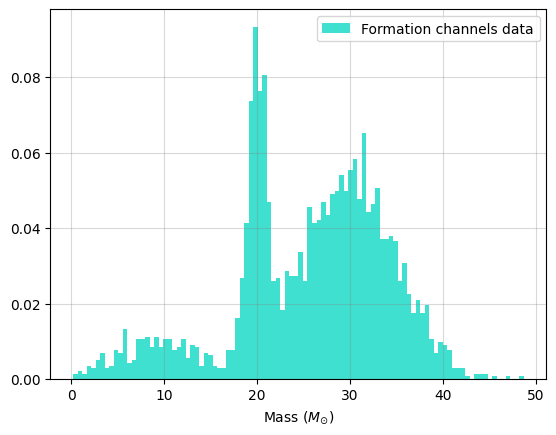

In [5]:
data_prov=np.load('../solutions/formationchannels.npy')
data_prov = data_prov[data_prov>0]     # Mass>0
data = data_prov[:, np.newaxis]

plt.hist(data, bins = 100, density=True, color='turquoise', histtype='stepfilled', label = 'Formation channels data')     # data>0 because they are masses
plt.xlabel('Mass ($M_{\\odot}$)')
plt.legend(loc='best')
plt.grid(c='grey', alpha = 0.3)
plt.show()

Judging by eye, there seems to be three modes.

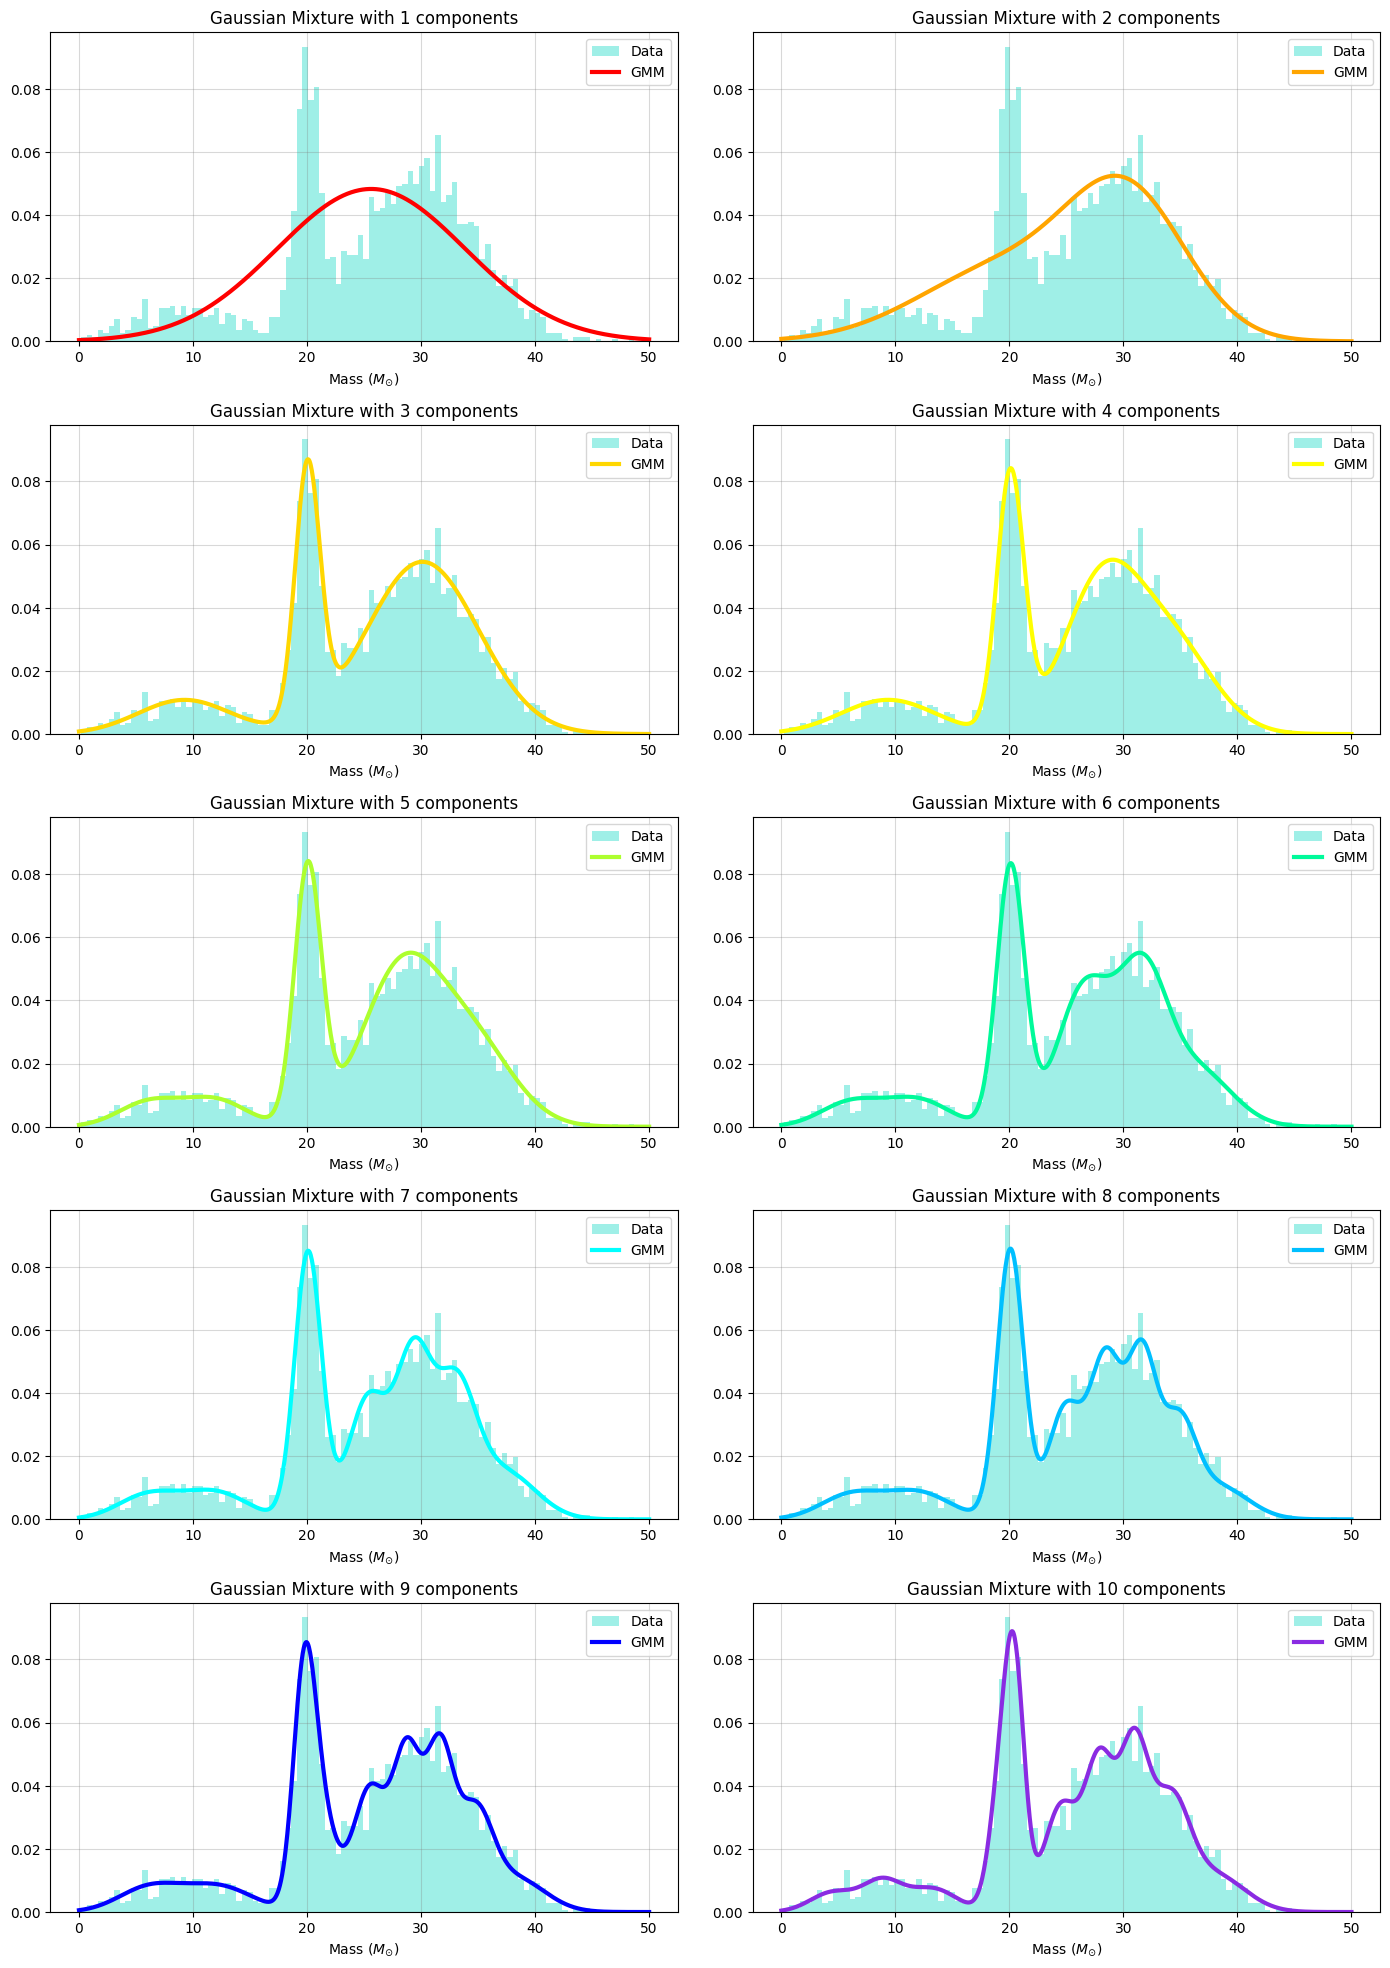

In [54]:
fig = plt.figure(figsize=(14, 25))
np.random.seed(336)

colors = ['red', 'orange', 'gold', 'yellow', 'greenyellow', 'mediumspringgreen', 'cyan', 'deepskyblue', 'blue', 'blueviolet']
n_comp = np.arange(10)

grid = np.linspace(0, 50, 1000).reshape(-1, 1)
AIC = np.empty(len(n_comp))

for n in n_comp:

    gm = GaussianMixture(n_components=n+1)     # Create the model
    gm.fit(data)     # Train the model on the data
    
    # Compute the log-likelihood on the grid points
    logL = gm.score_samples(grid)
    pdf = np.exp(logL)
    AIC[n] = gm.aic(data)
    
    ax = fig.add_subplot(6,2,n+1)
    
    ax.hist(data, bins = 100, density=True, color='turquoise', histtype='stepfilled', alpha = 0.5, label = 'Data')
    ax.plot(grid, pdf, color = colors[n], lw = 3, label = 'GMM')
    ax.set_xlabel('Mass ($M_{\\odot}$)')
    ax.legend(loc='best')
    ax.grid(alpha=0.3, c='gray')
    ax.set_title('Gaussian Mixture with %i components' %(n+1))

plt.tight_layout(rect=[0, 0.05, 1, 0.98], w_pad=2.5)
plt.show()

Using a Gaussian mixture model with n components, it's clear that 1 and 2 components aren't enough to capture the data behavior. The 3- and 4-components models are very similar and fit the data well. Higher components numbers fit the data very well, but they seem to be overfitting it.

Let's plot the AIC to see which model is best:

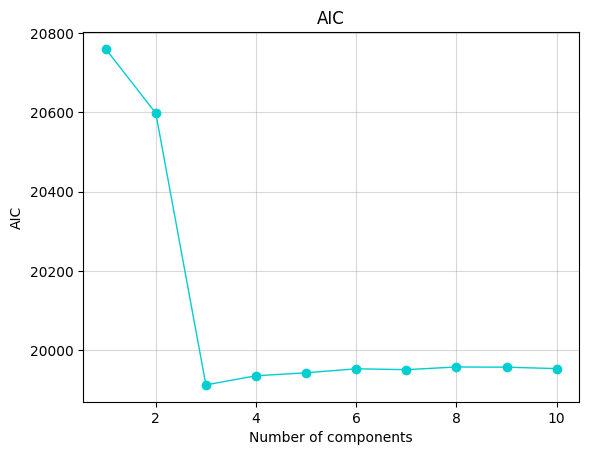

In [7]:
plt.plot(n_comp+1, AIC, marker = 'o', color = 'darkturquoise', lw = 1)
plt.grid(c='grey', alpha = 0.3)
plt.xlabel('Number of components')
plt.ylabel('AIC')
plt.title('AIC')
plt.show()

According to the AIC, the preferred solution is the 3-components GMM, as expected before.

Since the AIC is similar for $n\geq3$ components, we can try using a different information criterion:

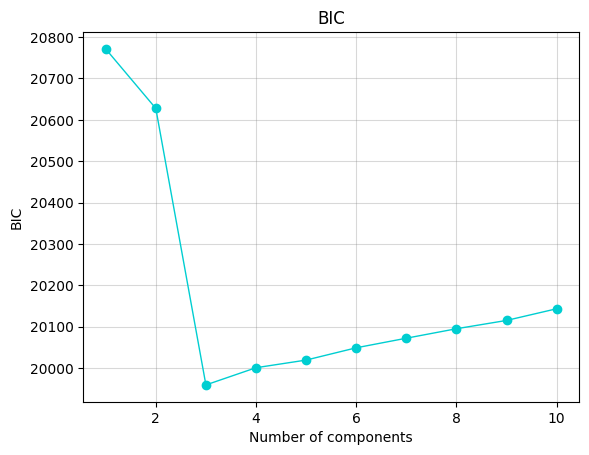

In [8]:
BIC = np.empty(len(n_comp))

for n in n_comp:

    gm = GaussianMixture(n_components=n+1)
    gm.fit(data)
    BIC[n] = gm.bic(data)

plt.plot(n_comp+1, BIC, marker = 'o', color = 'darkturquoise', lw = 1)
plt.grid(c='grey', alpha = 0.3)
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.title('BIC')
plt.show()

The BIC also agrees that the best model is the 3-components one.

We can plot now the single components:

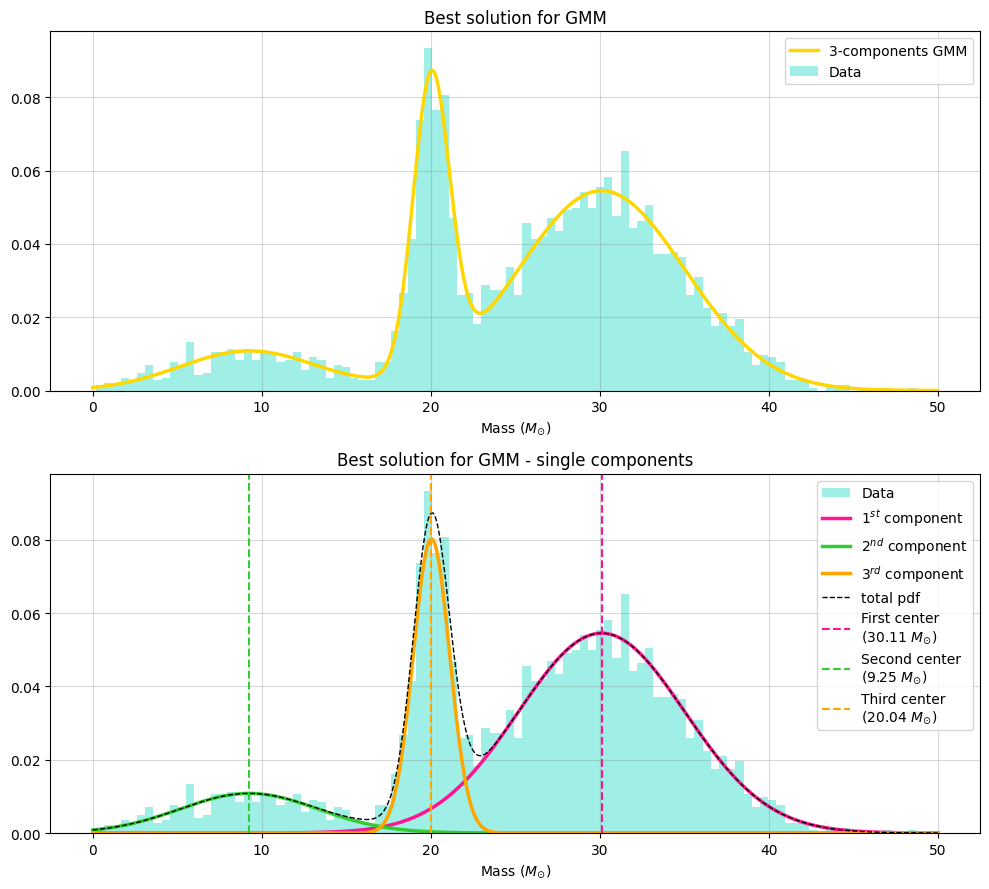

In [62]:
np.random.seed(336)
fig, ax = plt.subplots(2, 1, figsize=(10, 9))

# Plotting the best solution
gm_best = GaussianMixture(n_components=3)
gm_best.fit(data)    

logL_best = gm_best.score_samples(grid)
pdf_best = np.exp(logL_best)

ax[0].plot(grid, pdf_best, c = 'gold', lw = 2.5, label = '3-components GMM')
ax[0].hist(data, bins = 100, density=True, color='turquoise', alpha = 0.5, histtype='stepfilled', label = 'Data')
ax[0].set_xlabel('Mass ($M_{\\odot}$)')
ax[0].legend(loc='best')
ax[0].grid(alpha=0.3, c='gray')
ax[0].set_title('Best solution for GMM')

#Plotting the component contributions:
contr = gm_best.predict_proba(grid)
pdf_contr = contr*pdf_best[:, np.newaxis]

centers = gm_best.means_

ax[1].hist(data, bins = 100, density=True, color='turquoise', alpha = 0.5, histtype='stepfilled', label = 'Data')
ax[1].plot(grid, pdf_contr[:,0], c = 'deeppink', lw = 2.5, label = '$1^{st}$ component')
ax[1].plot(grid, pdf_contr[:,1], c = 'limegreen', lw = 2.5, label = '$2^{nd}$ component')
ax[1].plot(grid, pdf_contr[:,2], c = 'orange', lw = 2.5, label = '$3^{rd}$ component')
ax[1].plot(grid, pdf_best, c='black', ls='--', lw = 1, label = 'total pdf')
ax[1].axvline(centers[0], c = 'deeppink', lw = 1.5, ls = '--', label = 'First center\n(%.2f $M_{\\odot}$)' % centers[0][0])
ax[1].axvline(centers[1], c = 'limegreen', lw = 1.5, ls = '--', label = 'Second center\n(%.2f $M_{\\odot}$)' % centers[1][0])
ax[1].axvline(centers[2], c = 'orange', lw = 1.5, ls = '--', label = 'Third center\n(%.2f $M_{\\odot}$)' % centers[2][0])
ax[1].set_xlabel('Mass ($M_{\\odot}$)')
ax[1].legend(loc='best')
ax[1].grid(alpha=0.3, c='gray')
ax[1].set_title('Best solution for GMM - single components')

plt.tight_layout(w_pad=2.5)
plt.show()

### Check: clustering with mean-shift

As another check, we can use the mean-shift clustering to see how many clusters it finds.

In [32]:
scaler = preprocessing.StandardScaler()     # Scaling the data
bandwidth = estimate_bandwidth(scaler.fit_transform(data))

ms = MeanShift(bandwidth=bandwidth)
ms.fit(scaler.fit_transform(data))

MeanShift(bandwidth=0.5968157924554331)

Number of estimated clusters: 3


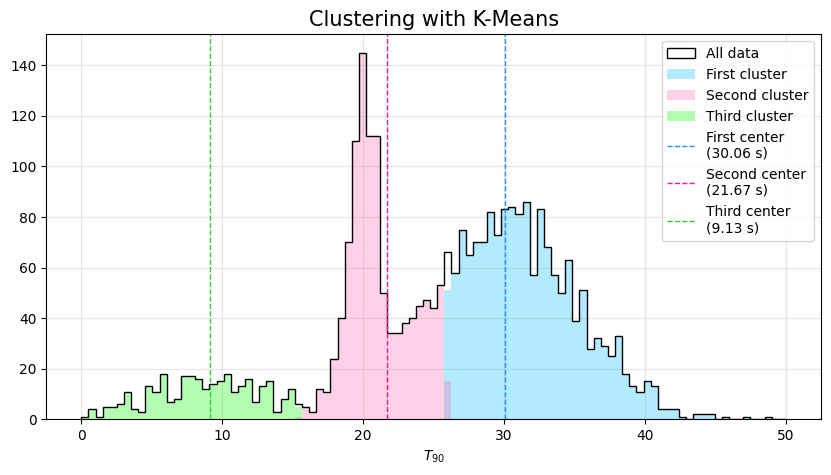

In [45]:
# Finding and rescaling the cluster centers
cluster_centers = ms.cluster_centers_
rescaled_centers = scaler.inverse_transform(cluster_centers)

# Finding the cluster labels and how many clusters there are, and assigning each datapoint to a cluster
labels = ms.labels_
labels_MS_unique = np.unique(labels)

n_clusters = len(labels_MS_unique[labels_MS_unique >= 0])
print("Number of estimated clusters: %i" % n_clusters)

data1 = data[labels==0]
data2 = data[labels==1]
data3 = data[labels==2]

Nbins = np.linspace(0, 50, 100)

plt.figure(figsize=(10, 5))

plt.hist(data, bins=Nbins, color='black', histtype = 'step', linewidth=1, label = 'All data')
plt.hist(data1, bins=Nbins, color='deepskyblue', alpha = 0.3, label = 'First cluster')
plt.hist(data2, bins=Nbins, color='hotpink', alpha = 0.3, label = 'Second cluster') 
plt.hist(data3, bins=Nbins, color='lime', alpha = 0.3, label = 'Third cluster')
plt.axvline(rescaled_centers[0], c = 'dodgerblue', lw = 1, ls = '--', label = 'First center\n(%.2f $M_{\\odot}$)' % rescaled_centers[0][0])
plt.axvline(rescaled_centers[1], c = 'deeppink', lw = 1, ls = '--', label = 'Second center\n(%.2f $M_{\\odot}$)' % rescaled_centers[1][0])
plt.axvline(rescaled_centers[2], c = 'limegreen', lw = 1, ls = '--', label = 'Third center\n(%.2f $M_{\\odot}$)' % rescaled_centers[2][0])
plt.grid(c='grey', alpha = 0.2)
plt.xlabel('$T_{90}$')
plt.title('Clustering with K-Means', fontsize = 15)
plt.legend(loc='upper right')
plt.show()

In [79]:
print('GMMC centers:')
for i in range(3):
    print('%.2f' % centers[i][0])

print('\nMeanShift centers:')
for i in range(3):
    print('%.2f' % rescaled_centers[i][0])

GMMC centers:
30.11
9.25
20.04

MeanShift centers:
30.06
21.67
9.13


So, the MeanShift algorithm also finds three clusters. The GMM centers and the Meanshift ones are pretty similar, but the Meanshift algorithm assigned more points to the central cluster than the GMM, "at the expenses" of the right cluster.